In [846]:
svtype <- 'TRA'
sample <- 'HTZ-SV'
truth_set_file <- '../../data/htz-sv.vcf'
regions_for_filtering <- '../../data/ENCFF001TDO.bed'
out_dir <- 'results'
mode <- 'gridss'

In [847]:
# SV callsets
callsets <- list()

callsets[['CNN']]  <- paste('../../scripts/genome_wide/labels/win500/', svtype, '/', mode, '/cnn_predictions.bedpe',sep='')
callsets[['GRIDSS']] <- '../../data/vcf/gridss_out/gridss.vcf'
callsets[['Manta']] <- '../../data/vcf/manta_out/manta.vcf'
callsets[['Lumpy']] <- '../../data/vcf/lumpy_out/lumpy.vcf'
callsets[['DELLY']] <- '../../data/vcf/delly_out/delly.vcf'

Load the [StructuralVariantAnnotation](https://bioconductor.org/packages/devel/bioc/vignettes/StructuralVariantAnnotation/inst/doc/vignettes.html) package

In [848]:
suppressPackageStartupMessages(require(StructuralVariantAnnotation))
suppressPackageStartupMessages(require(dplyr))
suppressPackageStartupMessages(require(ggplot2))

[SV type inference](https://github.com/PapenfussLab/gridss/blob/7b1fedfed32af9e03ed5c6863d368a821a4c699f/example/simple-event-annotation.R#L9)

In [849]:
infer_svtype <- function(gr)
{
  gr$svtype <-
    ifelse(
      seqnames(gr) != seqnames(partner(gr)),
      "TRA", # Using TRA instead of ITX or BP
      ifelse(
        gr$insLen >= abs(gr$svLen) * 0.7,
        "INS",
        ifelse(
          strand(gr) == strand(partner(gr)),
          "INV",
          ifelse(xor(
            start(gr) < start(partner(gr)), strand(gr) == "-"
          ), "DEL",
          "DUP")
        )
      )
    )
  return(gr)
}

In [850]:
load_bed <- function(bed_file)
{
    bed_regions <- rtracklayer::import(bed_file)
    # set NCBI seqlevels
    seqlevelsStyle(bed_regions) <- "NCBI"
    return(bed_regions)
}

In [851]:
load_bedpe <- function(bedpe_file, filter_regions)
{
  bedpe_gr <- pairs2breakpointgr(rtracklayer::import(bedpe_file))
  bedpe_gr <- filter_regions(bedpe_gr, load_bed(filter_regions), mode='remove')
  return(bedpe_gr)
}

In [852]:
load_vcf <- function(vcf_file, svtype, caller, filter_regions)
{
  
    # Load VCF file
    vcf_gr <-
      VariantAnnotation::readVcf(vcf_file)
    
    # set NCBI seqlevels
    seqlevelsStyle(vcf_gr) <- 'NCBI'
    
    if(caller=='survivor')
    {
        # update info header
        info(header(vcf_gr)) <- rbind(info(header(vcf_gr)),
                                      data.frame(Number = '4', Type = 'String', Description = 'DELLY CT'))
        # update info
        info(vcf_gr) <- cbind(info(vcf_gr), 
                              data.frame(CT=factor(rep('3to5',nrow(info(vcf_gr))), 
                                                   levels=c('5to5', '3to3', '3to5', '5to3'))))
        # TRA
        idx <- which(info(vcf_gr)$SVTYPE=='TRA')
        info(vcf_gr)$CT[idx[seq(1, length(idx), by=2)]]  <- '3to3'
        info(vcf_gr)$CT[idx[seq(2, length(idx), by=2)]]  <- '5to5'
        
        # INV
        idx <- which(info(vcf_gr)[['SVTYPE']]=='INV')
        info(vcf_gr)$CT[idx[seq(1, length(idx), by=2)]]  <- '3to5'
        info(vcf_gr)$CT[idx[seq(2, length(idx), by=2)]]  <- '5to3'
        
        # other SVTYPEs
        idx <- which(!info(vcf_gr)[['SVTYPE']]%in%c('INV','TRA'))
        info(vcf_gr)$CT[idx]  <- '3to5'
        
        # SURVIVOR simSV assigns LowQual to all artificial SVs
        vcf_gr <- vcf_gr[rowRanges(vcf_gr)$FILTER%in%c("LowQual")]
        
        if(svtype == 'INS')
        {
            info(vcf_gr)$END <- end(ranges(rowRanges(vcf_gr)))
        }

    }else{
        # Keep only SVs that passed the filtering (PASS or .)
        vcf_gr <- vcf_gr[rowRanges(vcf_gr)$FILTER%in%c("PASS",".")]
    }

    if (caller == 'lumpy')
    {
      # Read evidence support as a proxy for QUAL
      support <- unlist(info(vcf_gr)$SU)
      fixed(vcf_gr)$QUAL <- support
    } else if (caller == 'delly')
    {
      # Split-read support plus Paired-end read support as a proxy for QUAL
      sr_support <- info(vcf_gr)$SR
      sr_support[is.na(vcf_gr)] <- 0
      fixed(vcf_gr)$QUAL <-
        sr_support + info(vcf_gr)$PE
    }
    
    vcf_gr <- breakpointRanges(vcf_gr)
    vcf_gr <- infer_svtype(vcf_gr)
    
    # Select only one SV type
    vcf_gr <- vcf_gr[which(vcf_gr$svtype == svtype)]

    # Select SVs >= 50 bp
    if(!svtype %in% c('TRA','INS'))
      {
        vcf_gr <- vcf_gr[abs(vcf_gr$svLen) >= 50]
      }
    
    #Filter regions
    vcf_gr <- filter_regions(vcf_gr, load_bed(filter_regions), mode='remove')
    return(vcf_gr)
}

In [853]:
filter_regions <- function(regions_to_filter, ref_regions, mode='remove')
{
    print(length(regions_to_filter))
  if (mode == 'keep')
  {
    result <- regions_to_filter[overlapsAny(regions_to_filter, ref_regions) &
         overlapsAny(partner(regions_to_filter), ref_regions), ]
  } else if (mode == 'remove'){
    result <- regions_to_filter[!(
      overlapsAny(regions_to_filter, ref_regions) |
        overlapsAny(partner(regions_to_filter), ref_regions)
    ), ]
  }
    print(length(result))
    return(result)
}

Load the truth set

In [854]:
truth_set <- load_vcf(truth_set_file, svtype, 'survivor', regions_for_filtering)
# truth_set <- truth_set[truth_set$sourceId==svtype]
length(truth_set)

Warning message:
“info fields with no header: CHR2,END,SVLEN,SVMETHOD,SVTYPE,AF”
Warning message:
“info fields with no header: CHR2,END,SVLEN,SVMETHOD,SVTYPE,AF,CT”
Warning message:
“info fields with no header: CHR2,END,SVLEN,SVMETHOD,SVTYPE,AF,CT”
Warning message:
“info fields with no header: CHR2,END,SVLEN,SVMETHOD,SVTYPE,AF,CT”
Warning message:
“info fields with no header: CHR2,END,SVLEN,SVMETHOD,SVTYPE,AF,CT”
Warning message:
“info fields with no header: CHR2,END,SVLEN,SVMETHOD,SVTYPE,AF,CT”
Warning message:
“info fields with no header: CHR2,END,SVLEN,SVMETHOD,SVTYPE,AF,CT”
Warning message in .breakpointRanges(x, ...):
“Found 1000 duplicate row names (duplicates renamed).”


[1] 4000
[1] 4000


[1] 4000

Load the SV callsets

In [855]:
sv_regions <- list()
sv_regions[['CNN']] <- load_bedpe(callsets[['CNN']], regions_for_filtering)
sv_regions[['GRIDSS']] <- load_vcf(callsets[['GRIDSS']], svtype, 'gridss', regions_for_filtering)
sv_regions[['Manta']] <- load_vcf(callsets[['Manta']], svtype, 'manta', regions_for_filtering)
sv_regions[['Lumpy']] <- load_vcf(callsets[['Lumpy']], svtype, 'lumpy', regions_for_filtering)
sv_regions[['DELLY']] <- load_vcf(callsets[['DELLY']], svtype, 'delly', regions_for_filtering)

[1] 3964
[1] 3964


Warning message in .breakpointRanges(x, ...):
“Removing 1 unpaired breakend variants gridss0_7528h”


[1] 3824
[1] 3824
[1] 3724
[1] 3724
[1] 7682
[1] 7682


Warning message in .breakpointRanges(x, ...):
“Removing 2081 unpaired breakend variants BND00000002, BND00000000, BND00000003, BND00000006, BND00000007, BND00000005, BND00000008, BND00000010, BND00000011, BND00000013, BND00000012, BND00000015, BND00000014, BND00000017, BND00000016, BND00000019, BND00000018, BND00000020, BND00000022, BND00000024, BND00000025, BND00000026, BND00000029, BND00000027, BND00000031, BND00000030, BND00000034, BND00000036, BND00000037, BND00000038, BND00000035, BND00000039, BND00000040, BND00000041, BND00000043, BND00000042, BND00000045, BND00000044, BND00000046, BND00000048, BND00000047, BND00000051, BND00000049, BND00000053, BND00000052, BND00000050, BND00000055, BND00000056, BND00000054, BND00000058, BND00000057, BND00000060, BND00000061, BND00000063, BND00000062, BND00000064, BND00000066, BND00000065, BND00000068, BND00000069, BND00000067, BND00000071, BND00000070, BND00000073, BND00000072, BND00000074, BND00000075, BND00000076, BND00000078, BND00000077, BN

[1] 0
[1] 0


In [856]:
# exclude callsets with zero calls
sv_regions <- sv_regions[sapply(sv_regions, length)!=0]

In [857]:
# rename NA. column of CNN into svLen
names(mcols(sv_regions[['CNN']]))[names(mcols(sv_regions[['CNN']]))=='NA.'] <- 'svLen'

Add SV caller name

In [858]:
for (c in names(sv_regions))
{
  sv_regions[[c]]$caller <- c
}

In [859]:
seqlengths(truth_set) <- c("12" = 2000000, "22" = 2000000)
for (c in names(sv_regions))
{
seqlengths(sv_regions[[c]]) <- c("12" = 2000000, "22" = 2000000)
}

In [860]:
hits <- findBreakpointOverlaps(
      sv_regions[['CNN']],
      sv_regions[['CNN']],
      # read pair based callers make imprecise calls.
      # A margin around the call position is required when matching with the truth set
      maxgap = 100,
      # Since we added a maxgap, we also need to restrict the mismatch between the
      # size of the events. We don't want to match a 100bp deletion with a
      # 5bp duplication. This will happen if we have a 100bp margin but don't also
      # require an approximate size match as well
      sizemargin = 0.25,
      ignore.strand = TRUE,
      # We also don't want to match a 20bp deletion with a 20bp deletion 80bp away
      # by restricting the margin based on the size of the event, we can make sure
      # that simple events actually do overlap
      restrictMarginToSizeMultiple = 0.5
    )
data <- as.data.frame(hits)
getfirst <- function(x){x[1]}
get_best_qual <- function(x){x[which.max(sv_regions[['CNN']]$QUAL[x])]}
aggdata <- aggregate(data$queryHits, by=list(data$subjectHits), FUN=get_best_qual)
sv_regions[['CNN']] <- sv_regions[['CNN']][unique(aggdata$x)]
sv_regions[['CNN']] <- sv_regions[['CNN']][sv_regions[['CNN']]$partner %in% names(sv_regions[['CNN']])]

Compute overlap

In [861]:
for (c in names(sv_regions))
{
  if(svtype == 'INS'){
      
  sv_regions[[c]]$truth_matches <-
    countBreakpointOverlaps(
    sv_regions[[c]],
    truth_set,
    # using a smaller margin for insertions, insertion location should be precise
    maxgap = 5,
    # sizemargin cannot be used for insertions
    # sizemargin = 0.25,
    ignore.strand = TRUE,
    restrictMarginToSizeMultiple = 0.5,
    # countOnlyBest cannot be used for insertions
    # countOnlyBest = TRUE
    )
      
  }else{
      
  sv_regions[[c]]$truth_matches <-
    countBreakpointOverlaps(
      sv_regions[[c]],
      truth_set,
      # read pair based callers make imprecise calls.
      # A margin around the call position is required when matching with the truth set
      maxgap = 200,
      # Since we added a maxgap, we also need to restrict the mismatch between the
      # size of the events. We don't want to match a 100bp deletion with a
      # 5bp duplication. This will happen if we have a 100bp margin but don't also
      # require an approximate size match as well
      sizemargin = 0.25,
      ignore.strand = TRUE,
      # We also don't want to match a 20bp deletion with a 20bp deletion 80bp away
      # by restricting the margin based on the size of the event, we can make sure
      # that simple events actually do overlap
      restrictMarginToSizeMultiple = 0.5,
      # Some callers make duplicate calls and will sometimes report a variant multiple
      # times with slightly different bounds. countOnlyBest prevents these being
      # double-counted as multiple true positives.
      countOnlyBest = TRUE
    )
    }
}
    
sv_regions_unlisted <- unlist(GRangesList(sv_regions))

Plotting Precision and Recall as in [StructuralVariantAnnotation vignette](https://bioconductor.org/packages/devel/bioc/vignettes/StructuralVariantAnnotation/inst/doc/vignettes.html)

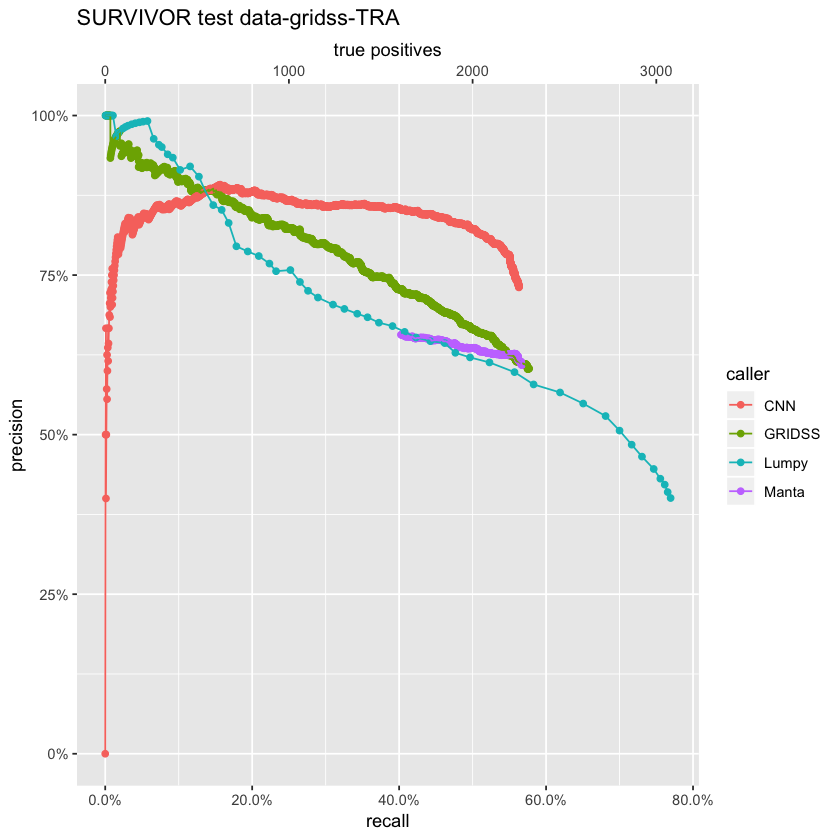

In [862]:
main.title <- paste("SURVIVOR test data", mode, svtype, sep='-')
names(main.title) <- c(sample)

ggplot(
  as.data.frame(sv_regions_unlisted) %>%
    dplyr::select(QUAL, caller, truth_matches) %>%
    dplyr::group_by(caller, QUAL) %>%
    dplyr::summarise(calls = n(),
                     tp = sum(truth_matches > 0)) %>%
    dplyr::group_by(caller) %>%
    dplyr::arrange(dplyr::desc(QUAL)) %>%
    dplyr::mutate(
      cum_tp = cumsum(tp),
      cum_n = cumsum(calls),
      cum_fp = cum_n - cum_tp,
      precision = cum_tp / cum_n,
      recall = cum_tp / length(truth_set)
    )
) +
  aes(x = recall,
      y = precision,
      colour = caller) +
  geom_point() +
  geom_line() +
  scale_y_continuous(labels = scales::percent) +
  scale_x_continuous(
    labels = scales::percent,
    sec.axis = sec_axis( ~ (.) * length(truth_set), name = "true positives")
  ) +
  labs(title = main.title[sample])

In [863]:
filename <- paste("SURVIVOR", mode, svtype, sep='_')
ggsave(file=paste(filename, 'png', sep='.'))

Saving 7 x 7 in image



In [864]:
make_percent <- function(x){
  signif(x*100,digits = 4)
}

Summarize results

In [865]:
res.df <- as.data.frame(sv_regions_unlisted) %>%
    dplyr::select(caller, truth_matches) %>%
    dplyr::group_by(caller) %>%
    dplyr::summarise(calls = n(),
                   TP = sum(truth_matches > 0)) %>%
    dplyr::group_by(caller) %>%
    dplyr::mutate(
    FP = calls - TP,
    precision = signif(TP / calls, digits = 4),
    recall = signif(TP / length(truth_set), digits = 4)
    )
res.df$F1_score = with(res.df, 2 * (precision * recall) / (precision + recall))
res.df$precision <- make_percent(res.df$precision)
res.df$recall <- make_percent(res.df$recall)
res.df$F1_score <- make_percent(res.df$F1_score)

In [866]:
res.df

caller,calls,TP,FP,precision,recall,F1_score
<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
CNN,3082,2252,830,73.07,56.30,63.60
GRIDSS,3824,2308,1516,60.36,57.70,59.00
Lumpy,7682,3078,4604,40.07,76.95,52.70
Manta,3724,2268,1456,60.90,56.70,58.72


In [867]:
write.csv(file=paste(filename, 'csv', sep='.'), res.df, quote=FALSE, row.names=FALSE)